In [6]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [47]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
VIDEO_FOLDER_PATH = 'videos'
PATH_FOR_IMAGES = 'images'
SEQUENCE_LENGTH=20

1. Extract frames from the video and store in new folder location in project directory

In [9]:
for folder in os.listdir(VIDEO_FOLDER_PATH):

    # TODO: Check if images folder exists, if not create it
    
    if not os.path.exists(os.path.join(PATH_FOR_IMAGES, folder)):
        os.mkdir(os.path.join(PATH_FOR_IMAGES, folder))

    for video_file in os.listdir(os.path.join(VIDEO_FOLDER_PATH, folder)):
        full_video_path = os.path.join(VIDEO_FOLDER_PATH, folder, video_file)
        video = cv2.VideoCapture(full_video_path)
        success, image = video.read()
        count = 0

        while success:
            video.set(cv2.CAP_PROP_POS_MSEC,(count*200))
            image_path = os.path.join(PATH_FOR_IMAGES, folder, "frame%d.jpg" % count)
            cv2.imwrite(image_path, image)
            success, image = video.read()
            count += 1

2. Create TensorFlow Datasets Objects consisting of images

In [10]:
PATH_FOR_IMAGES = pathlib.Path(PATH_FOR_IMAGES)
total_image_count = len(list(PATH_FOR_IMAGES.glob('**/*.jpg')))
list_ds = tf.data.Dataset.list_files(str(PATH_FOR_IMAGES/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(total_image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in PATH_FOR_IMAGES.glob('*') if item.is_dir()]))

# Creating Dataset partitions
# TODO: Create test partition
validation_percentage = 0.2
validation_set_size = int(total_image_count * validation_percentage)
training_set_size = total_image_count - validation_set_size
validation_set = list_ds.take(validation_set_size)
training_set = list_ds.skip(validation_set_size)

print(tf.data.experimental.cardinality(training_set).numpy())
print(tf.data.experimental.cardinality(validation_set).numpy())



230
57


3. Create image, label pair data points

In [41]:
def extract_label_from_path(image_path):
    parts = tf.strings.split(image_path, os.path.sep)
    one_hot = tf.dtypes.cast(parts[-2] == class_names, tf.int16)
    return tf.argmax(one_hot)


def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(image_path):
    label = extract_label_from_path(image_path)
    img = tf.io.read_file(image_path)
    img = decode_image(img)
    return img, label

train_ds = training_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_ds = validation_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.batch(20, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.batch(20, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for i in train_ds:
    print(i[0].shape)

(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)
(20, 180, 180, 3)


In [42]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
validation_ds = configure_for_performance(validation_ds)

TypeError: Invalid shape (20, 180, 180, 3) for image data

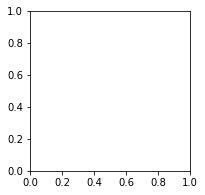

In [43]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

4. Neural Network Implementation
* We might not need to actually shuffle the dataset as we want to capture temporal relationship
* Need to consider the sequence length 


In [48]:
model = keras.Sequential()

model.add(keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_24 (ConvLSTM2D) (None, 20, 180, 180, 16)  11008     
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 20, 90, 90, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 90, 90, 16)    0         
_________________________________________________________________
conv_lst_m2d_25 (ConvLSTM2D) (None, 20, 90, 90, 32)    55424     
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 20, 45, 45, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 45, 45, 32)    0         
_________________________________________________________________
conv_lst_m2d_26 (ConvLSTM2D) (None, 20, 45, 45, 64)   

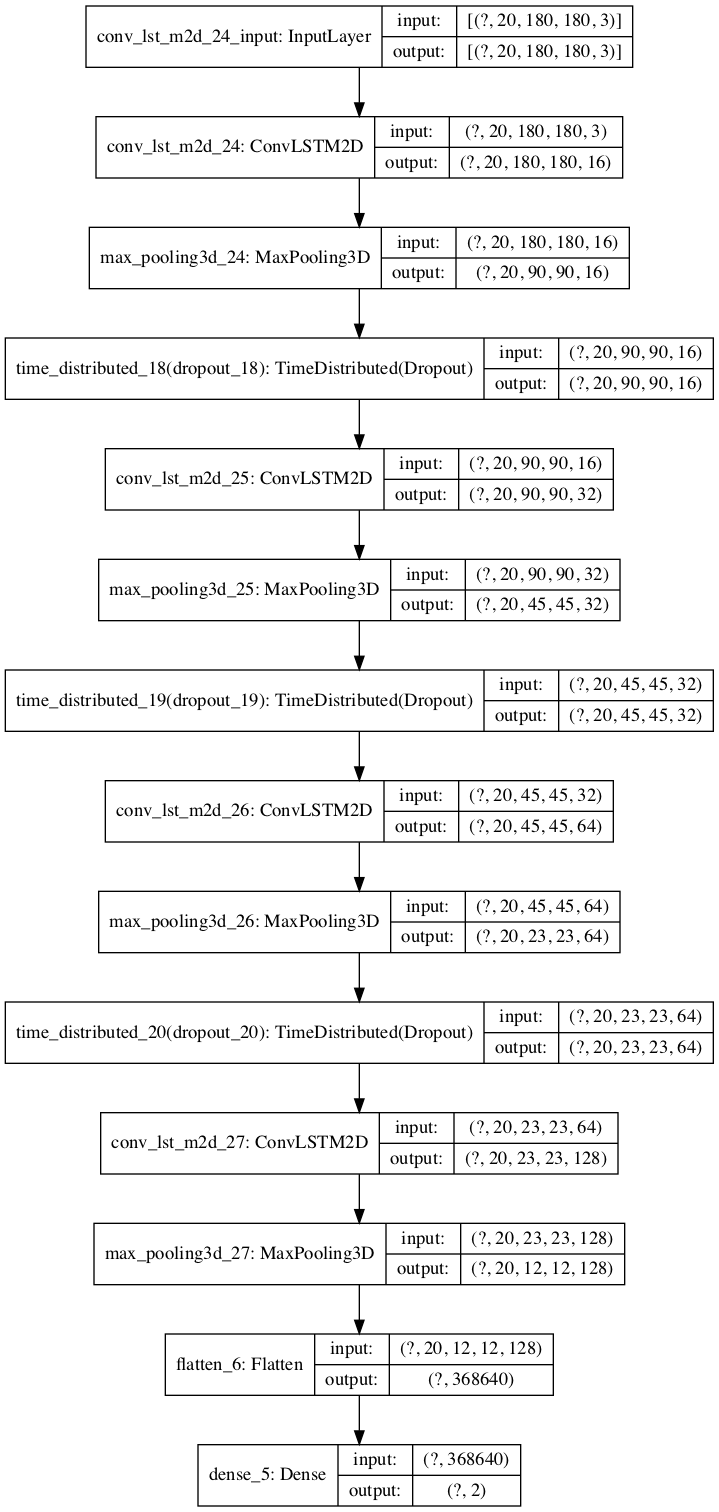

In [49]:
plot_model(model, to_file='model.png', show_shapes=True)

In [50]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=10, validation_data=validation_ds, steps_per_epoch=100, validation_steps=10)

Train for 100 steps, validate for 10 steps
Epoch 1/10


2022-01-10 11:04:22.908611: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Invalid argument: logits and labels must be broadcastable: logits_size=[11,2] labels_size=[11,20]
	 [[{{node loss/dense_5_loss/softmax_cross_entropy_with_logits}}]]


  1/100 [..............................] - ETA: 9:24:58

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[11,2] labels_size=[11,20]
	 [[node loss/dense_5_loss/softmax_cross_entropy_with_logits (defined at Users/loveshark/opt/anaconda3/envs/movedetection/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_74826]

Function call stack:
distributed_function
